<a href="https://colab.research.google.com/github/KunalSRM/ResNet-18-FineTune/blob/main/Fine_Tuning_CV_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================================================
# 1. Install dependencies
# =========================================================
!pip install torch torchvision torchaudio torchmetrics pytorch-grad-cam -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# =========================================================
# 2. Data Loading (PlantVillage dataset example)
# =========================================================
# ⚠️ If running on Kaggle: dataset already in input folder
# ⚠️ If running on Colab: upload manually or use gdown to fetch from Kaggle

data_dir = "/kaggle/input/plantdisease/PlantVillage"  # Change path if needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Classes:", class_names)

# =========================================================
# 3. Load Pretrained Model & Modify
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False   # freeze backbone

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # new classifier head
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# =========================================================
# 4. Training Loop (few epochs for demo)
# =========================================================
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate_model(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    acc = running_corrects.double() / len(loader.dataset)
    return acc.item()

EPOCHS = 3
for epoch in range(EPOCHS):
    loss, acc = train_model(model, train_loader, criterion, optimizer)
    val_acc = evaluate_model(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

# =========================================================
# 5. Grad-CAM Visualization
# =========================================================
target_layer = model.layer4[-1]  # last conv block
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# Pick one validation image
inputs, labels = next(iter(val_loader))
input_tensor = inputs[0].unsqueeze(0).to(device)

grayscale_cam = cam(input_tensor=input_tensor)[0, :]
rgb_img = np.transpose(inputs[0].numpy(), (1,2,0))
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # normalize for display

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(rgb_img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(visualization)
plt.axis("off")
plt.show()


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [2]:
!pip install grad-cam -q



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.
Path to dataset files: /kaggle/input/plantvillage-dataset


In [4]:
# =========================================================
# 1. Install dependencies
# =========================================================
!pip install grad-cam torchmetrics -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# =========================================================
# 2. Data Loading (PlantVillage dataset example)
# =========================================================
# 👉 If on Kaggle: dataset path = "/kaggle/input/plantdisease/PlantVillage"
# 👉 If on Colab: upload dataset or mount Google Drive

data_dir = "/kaggle/input/plantdisease/PlantVillage"  # change if needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Classes:", class_names)

# =========================================================
# 3. Load Pretrained Model & Modify
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False   # freeze backbone

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # new classifier head
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# =========================================================
# 4. Training Loop (few epochs for demo)
# =========================================================
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate_model(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    acc = running_corrects.double() / len(loader.dataset)
    return acc.item()

EPOCHS = 3
for epoch in range(EPOCHS):
    loss, acc = train_model(model, train_loader, criterion, optimizer)
    val_acc = evaluate_model(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

# =========================================================
# 5. Grad-CAM Visualization (multiple images)
# =========================================================
target_layer = model.layer4[-1]  # last conv block
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# pick a few validation images
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

plt.figure(figsize=(12, 8))
for i in range(4):  # show 4 examples
    input_tensor = inputs[i].unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    rgb_img = np.transpose(inputs[i].cpu().numpy(), (1,2,0))
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(2,4,i*2+1)
    plt.title(f"True: {class_names[labels[i]]}")
    plt.imshow(rgb_img)
    plt.axis("off")

    plt.subplot(2,4,i*2+2)
    plt.title("Grad-CAM")
    plt.imshow(visualization)
    plt.axis("off")

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.3 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/plantdisease/PlantVillage/train'

In [5]:
# =========================================================
# 1. Install dependencies
# =========================================================
!pip install grad-cam -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# =========================================================
# 2. Load CIFAR-10 Dataset (small dataset)
# =========================================================
transform = transforms.Compose([
    transforms.Resize((224,224)),  # resize for ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

classes = trainset.classes
print("Classes:", classes)

# =========================================================
# 3. Load Pretrained ResNet50
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(pretrained=True)

# freeze backbone
for param in model.parameters():
    param.requires_grad = False

# replace classifier head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# =========================================================
# 4. Training (short demo training)
# =========================================================
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_corrects = 0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(loader.dataset), running_corrects.double()/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
    return running_corrects.double()/len(loader.dataset)

EPOCHS = 2  # keep small for laptop demo
for epoch in range(EPOCHS):
    loss, acc = train_one_epoch(model, trainloader)
    test_acc = evaluate(model, testloader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Test Acc: {test_acc:.4f}")

# =========================================================
# 5. Grad-CAM Visualization
# =========================================================
target_layer = model.layer4[-1]  # last conv block
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# get a few test images
dataiter = iter(testloader)
images, labels = next(dataiter)

plt.figure(figsize=(12,8))
for i in range(4):
    input_tensor = images[i].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    rgb_img = np.transpose(images[i].numpy(), (1,2,0))
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(2,4,i*2+1)
    plt.title(f"True: {classes[labels[i]]}")
    plt.imshow(rgb_img)
    plt.axis("off")

    plt.subplot(2,4,i*2+2)
    plt.title("Grad-CAM")
    plt.imshow(visualization)
    plt.axis("off")

plt.tight_layout()
plt.show()


100%|██████████| 170M/170M [00:04<00:00, 39.3MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Epoch 1/2 | Loss: 0.7583 | Train Acc: 0.7433 | Test Acc: 0.7885


Exception ignored in: <function BaseCAM.__del__ at 0x78cfd297eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_grad_cam/base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Epoch 2/2 | Loss: 0.6253 | Train Acc: 0.7819 | Test Acc: 0.7966


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

In [6]:
# =========================================================
# 1. Install dependencies
# =========================================================
!pip install grad-cam -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# =========================================================
# 2. Load CIFAR-10 Dataset with Data Augmentation
# =========================================================
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

classes = trainset.classes
print("Classes:", classes)

# =========================================================
# 3. Load Pretrained ResNet50
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# freeze backbone initially
for param in model.parameters():
    param.requires_grad = False

# unfreeze last 2 residual blocks for better fine-tuning
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# replace classifier head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003)

# =========================================================
# 4. Training Loop
# =========================================================
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_corrects = 0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(loader.dataset), running_corrects.double()/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
    return running_corrects.double()/len(loader.dataset)

EPOCHS = 25
for epoch in range(EPOCHS):
    loss, acc = train_one_epoch(model, trainloader)
    test_acc = evaluate(model, testloader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Test Acc: {test_acc:.4f}")

# =========================================================
# 5. Grad-CAM Visualization (Random 4 images)
# =========================================================
target_layer = model.layer4[-1]  # last conv block
cam = GradCAM(model=model, target_layers=[target_layer])

dataiter = iter(testloader)
images, labels = next(dataiter)

plt.figure(figsize=(12,8))
for i in range(4):
    input_tensor = images[i].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    rgb_img = np.transpose(images[i].numpy(), (1,2,0))
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(2,4,i*2+1)
    plt.title(f"True: {classes[labels[i]]}")
    plt.imshow(rgb_img)
    plt.axis("off")

    plt.subplot(2,4,i*2+2)
    plt.title("Grad-CAM")
    plt.imshow(visualization)
    plt.axis("off")

plt.tight_layout()
plt.show()

# =========================================================
# 6. Class-wise Average Grad-CAM (Novelty)
# =========================================================
def class_average_cam(model, loader, target_layer, class_idx, max_images=50):
    cam = GradCAM(model=model, target_layers=[target_layer])
    images_collected = 0
    avg_cam = None
    for inputs, labels in loader:
        for i in range(len(labels)):
            if labels[i].item() == class_idx:
                input_tensor = inputs[i].unsqueeze(0).to(device)
                grayscale_cam = cam(input_tensor=input_tensor)[0, :]
                if avg_cam is None:
                    avg_cam = grayscale_cam
                else:
                    avg_cam += grayscale_cam
                images_collected += 1
                if images_collected >= max_images:
                    return avg_cam / images_collected
    return avg_cam / max(1, images_collected)

# Example: Compare "cat" vs "dog" average attention
cat_idx = classes.index("cat")
dog_idx = classes.index("dog")

avg_cam_cat = class_average_cam(model, testloader, target_layer, cat_idx)
avg_cam_dog = class_average_cam(model, testloader, target_layer, dog_idx)

# Plot average attention maps
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Average Grad-CAM: Cat")
plt.imshow(avg_cam_cat, cmap='jet')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Average Grad-CAM: Dog")
plt.imshow(avg_cam_dog, cmap='jet')
plt.axis("off")
plt.show()


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


KeyboardInterrupt: 

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 1/12 | Loss: 0.6493 | Train Acc: 0.7761 | Test Acc: 0.8333
Epoch 2/12 | Loss: 0.3843 | Train Acc: 0.8643 | Test Acc: 0.8568
Epoch 3/12 | Loss: 0.2946 | Train Acc: 0.8980 | Test Acc: 0.8550
Epoch 4/12 | Loss: 0.2240 | Train Acc: 0.9218 | Test Acc: 0.8698
Epoch 5/12 | Loss: 0.1902 | Train Acc: 0.9352 | Test Acc: 0.8756
Epoch 6/12 | Loss: 0.1691 | Train Acc: 0.9435 | Test Acc: 0.8825
Epoch 7/12 | Loss: 0.1300 | Train Acc: 0.9560 | Test Acc: 0.8709
Epoch 8/12 | Loss: 0.1297 | Train Acc: 0.9540 | Test Acc: 0.8708
Epoch 9/12 | Loss: 0.1114 | Train Acc: 0.9608 | Test Acc: 0.8870
Epoch 10/12 | Loss: 0.1027 | Train Acc: 0.9651 | Test Acc: 0.8836
Epoch 11/12 | Loss: 0.0867 | Train Acc: 0.9718 | Test Acc: 0.8823
Epoch 12/12 | Loss: 0.0832 | Train Acc: 0.9712 | Test Acc: 0.8802


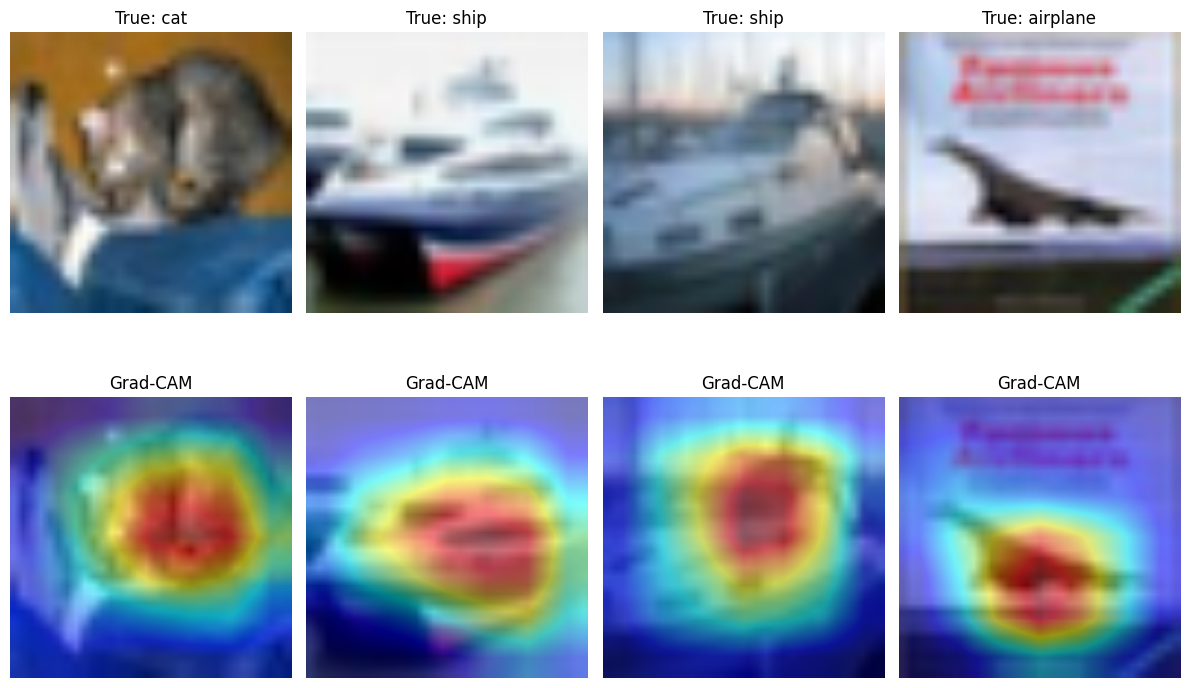

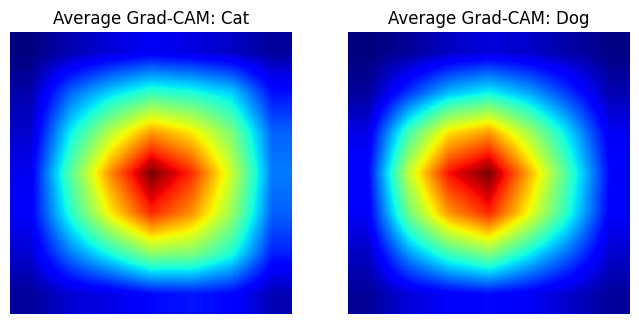

In [1]:
# =========================================================
# IMPORTS & DEPENDENCIES
# =========================================================
!pip install grad-cam -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================================================
# 1. DATA LOADING FUNCTION
# =========================================================
def load_cifar10(batch_size=32, subset_size=10000):
    transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # Use subset for fast demo
    subset_indices = list(range(subset_size))
    trainset = torch.utils.data.Subset(trainset_full, subset_indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, trainset_full.classes

# =========================================================
# 2. MODEL BUILDING FUNCTION
# =========================================================
def build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Freeze backbone
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Unfreeze specified layers
    for layer_name in fine_tune_layers:
        layer = getattr(model, layer_name)
        for param in layer.parameters():
            param.requires_grad = True

    # Replace classifier head
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

# =========================================================
# 3. TRAINING & EVALUATION FUNCTIONS
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_corrects = 0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(loader.dataset), running_corrects.double()/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
    return running_corrects.double()/len(loader.dataset)

def train_model(model, trainloader, testloader, epochs=12, lr=0.0005):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainloader, optimizer, criterion)
        test_acc = evaluate(model, testloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Test Acc: {test_acc:.4f}")
    return model

# =========================================================
# 4. GRAD-CAM VISUALIZATION FUNCTION
# =========================================================
def gradcam_visualize(model, images, labels, classes, target_layer, max_images=4):
    cam = GradCAM(model=model, target_layers=[target_layer])
    plt.figure(figsize=(12,8))
    for i in range(min(max_images, len(images))):
        input_tensor = images[i].unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        rgb_img = np.transpose(images[i].numpy(), (1,2,0))
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(2, max_images, i+1)
        plt.title(f"True: {classes[labels[i]]}")
        plt.imshow(rgb_img)
        plt.axis("off")

        plt.subplot(2, max_images, i+1+max_images)
        plt.title("Grad-CAM")
        plt.imshow(visualization)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# =========================================================
# 5. CLASS-WISE AVERAGE GRAD-CAM FUNCTION
# =========================================================
def class_average_gradcam(model, loader, target_layer, class_idx, max_images=10):
    cam = GradCAM(model=model, target_layers=[target_layer])
    images_collected = 0
    avg_cam = None
    for inputs, labels in loader:
        for i in range(len(labels)):
            if labels[i].item() == class_idx:
                input_tensor = inputs[i].unsqueeze(0).to(device)
                grayscale_cam = cam(input_tensor=input_tensor)[0, :]
                if avg_cam is None:
                    avg_cam = grayscale_cam
                else:
                    avg_cam += grayscale_cam
                images_collected += 1
                if images_collected >= max_images:
                    return avg_cam / images_collected
    return avg_cam / max(1, images_collected)

def plot_average_cams(avg_cams, titles):
    plt.figure(figsize=(4*len(avg_cams),4))
    for i, cam in enumerate(avg_cams):
        plt.subplot(1,len(avg_cams),i+1)
        plt.title(titles[i])
        plt.imshow(cam, cmap='jet')
        plt.axis("off")
    plt.show()

# =========================================================
# 6. RUNNING THE PROJECT
# =========================================================
trainloader, testloader, classes = load_cifar10(batch_size=32, subset_size=10000)
model = build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=len(classes))
model = train_model(model, trainloader, testloader, epochs=12, lr=0.0005)

# Grad-CAM on 4 random test images
dataiter = iter(testloader)
images, labels = next(dataiter)
gradcam_visualize(model, images, labels, classes, target_layer=model.layer4[-1], max_images=4)

# Class-wise average Grad-CAM for 'cat' vs 'dog'
cat_idx = classes.index("cat")
dog_idx = classes.index("dog")
avg_cam_cat = class_average_gradcam(model, testloader, model.layer4[-1], cat_idx, max_images=10)
avg_cam_dog = class_average_gradcam(model, testloader, model.layer4[-1], dog_idx, max_images=10)
plot_average_cams([avg_cam_cat, avg_cam_dog], ["Average Grad-CAM: Cat", "Average Grad-CAM: Dog"])


Using device: cuda
[layer4] Epoch 1/8 | Loss: 0.6516 | Train Acc: 0.7730 | Test Acc: 0.8411
[layer4] Epoch 2/8 | Loss: 0.3776 | Train Acc: 0.8764 | Test Acc: 0.8584
[layer4] Epoch 3/8 | Loss: 0.2881 | Train Acc: 0.9024 | Test Acc: 0.8623
[layer4] Epoch 4/8 | Loss: 0.2361 | Train Acc: 0.9165 | Test Acc: 0.8655
[layer4] Epoch 5/8 | Loss: 0.1977 | Train Acc: 0.9343 | Test Acc: 0.8826
[layer4] Epoch 6/8 | Loss: 0.1654 | Train Acc: 0.9429 | Test Acc: 0.8759
[layer4] Epoch 7/8 | Loss: 0.1488 | Train Acc: 0.9487 | Test Acc: 0.8754
[layer4] Epoch 8/8 | Loss: 0.1174 | Train Acc: 0.9615 | Test Acc: 0.8832
[layer3_4] Epoch 1/8 | Loss: 0.6830 | Train Acc: 0.7646 | Test Acc: 0.8433
[layer3_4] Epoch 2/8 | Loss: 0.3966 | Train Acc: 0.8649 | Test Acc: 0.8183
[layer3_4] Epoch 3/8 | Loss: 0.3049 | Train Acc: 0.8970 | Test Acc: 0.8658
[layer3_4] Epoch 4/8 | Loss: 0.2599 | Train Acc: 0.9131 | Test Acc: 0.8491
[layer3_4] Epoch 5/8 | Loss: 0.1946 | Train Acc: 0.9315 | Test Acc: 0.8647
[layer3_4] Epoch 6/8 |

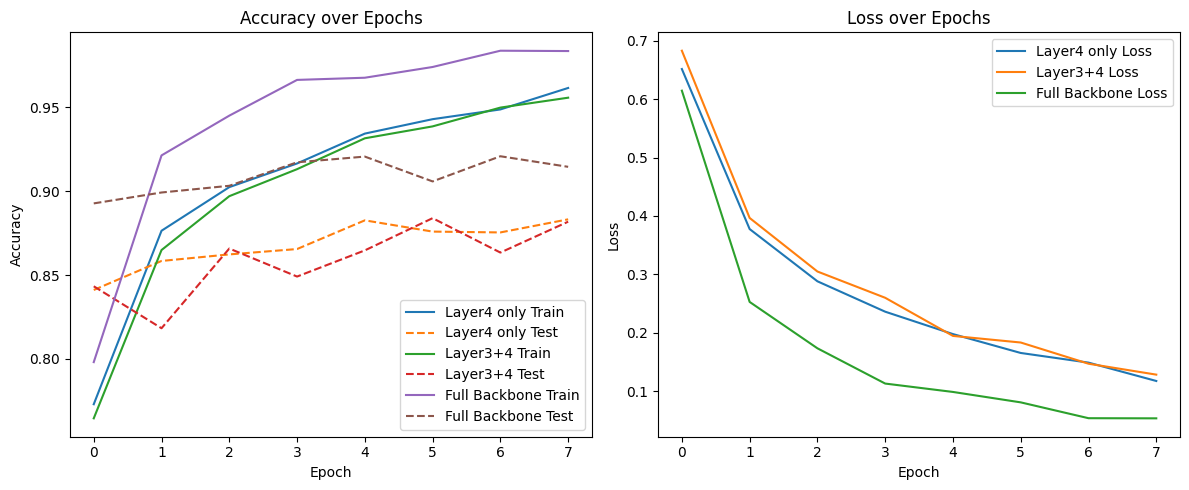

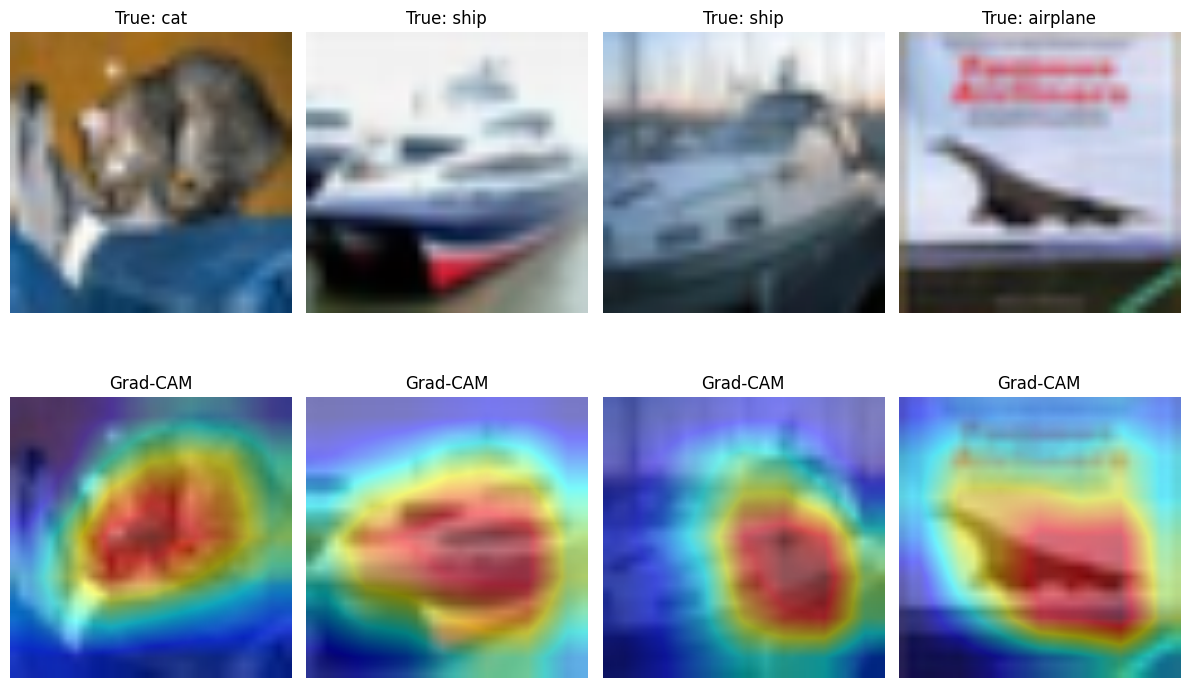

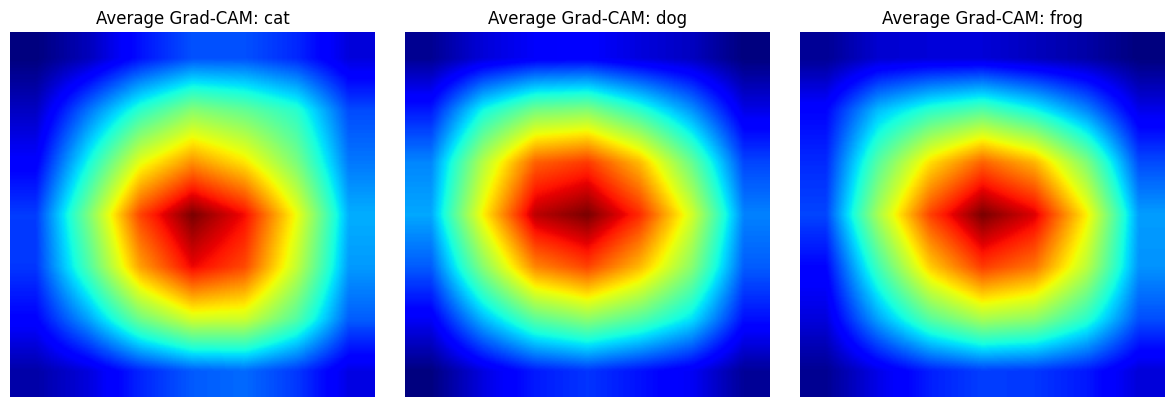

In [2]:
# =========================================================
# CIFAR-10 Gradual Fine-Tuning with Grad-CAM
# GitHub-Ready Version
# =========================================================

# ------------------- 1. Install Dependencies -------------------
!pip install grad-cam -q

# ------------------- 2. Imports -------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 3. Create folders for outputs -------------------
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# ------------------- 4. Data Loading -------------------
def load_cifar10(batch_size=32, subset_size=10000):
    transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    subset_indices = list(range(subset_size))
    trainset = torch.utils.data.Subset(trainset_full, subset_indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, trainset_full.classes

# ------------------- 5. Model Building -------------------
def build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    for layer_name in fine_tune_layers:
        layer = getattr(model, layer_name)
        for param in layer.parameters():
            param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

# ------------------- 6. Training Functions -------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_corrects = 0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(loader.dataset), running_corrects.double()/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
    return running_corrects.double()/len(loader.dataset)

def train_model_with_history(model, trainloader, testloader, epochs=8, lr=0.0005, phase_name="phase"):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_acc': [], 'test_acc': [], 'loss': []}

    for epoch in range(epochs):
        loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion)
        test_acc = evaluate(model, testloader)

        history['loss'].append(loss)
        history['train_acc'].append(train_acc.item())
        history['test_acc'].append(test_acc.item())

        print(f"[{phase_name}] Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f"models/model_{phase_name}.pth")

    return model, history

# ------------------- 7. History Plot Function -------------------
def plot_history(histories, labels):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    for h,label in zip(histories,labels):
        plt.plot(h['train_acc'], label=f"{label} Train")
        plt.plot(h['test_acc'], '--', label=f"{label} Test")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    for h,label in zip(histories,labels):
        plt.plot(h['loss'], label=f"{label} Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("plots/accuracy_loss_comparison.png", dpi=200)
    plt.show()

# ------------------- 8. Grad-CAM Functions -------------------
def gradcam_visualize(model, images, labels, classes, target_layer, max_images=4, save_dir="plots"):
    cam = GradCAM(model=model, target_layers=[target_layer])
    plt.figure(figsize=(12,8))

    for i in range(min(max_images, len(images))):
        input_tensor = images[i].unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        rgb_img = np.transpose(images[i].numpy(), (1,2,0))
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Original image
        plt.subplot(2, max_images, i+1)
        plt.title(f"True: {classes[labels[i]]}")
        plt.imshow(rgb_img)
        plt.axis("off")

        # Grad-CAM
        plt.subplot(2, max_images, i+1+max_images)
        plt.title("Grad-CAM")
        plt.imshow(visualization)
        plt.axis("off")

        # Save individual Grad-CAM
        plt.imsave(f"{save_dir}/gradcam_{classes[labels[i]]}_{i}.png", visualization)

    plt.tight_layout()
    plt.savefig(f"{save_dir}/gradcam_visualization.png", dpi=200)
    plt.show()

def class_average_gradcam(model, loader, target_layer, class_idx, max_images=10):
    cam = GradCAM(model=model, target_layers=[target_layer])
    images_collected = 0
    avg_cam = None
    for inputs, labels in loader:
        for i in range(len(labels)):
            if labels[i].item() == class_idx:
                input_tensor = inputs[i].unsqueeze(0).to(device)
                grayscale_cam = cam(input_tensor=input_tensor)[0, :]
                if avg_cam is None:
                    avg_cam = grayscale_cam
                else:
                    avg_cam += grayscale_cam
                images_collected += 1
                if images_collected >= max_images:
                    return avg_cam / images_collected
    return avg_cam / max(1, images_collected)

def plot_average_cams(avg_cams, titles, save_dir="plots"):
    plt.figure(figsize=(4*len(avg_cams),4))
    for i, cam in enumerate(avg_cams):
        plt.subplot(1,len(avg_cams),i+1)
        plt.title(titles[i])
        plt.imshow(cam, cmap='jet')
        plt.axis("off")
        plt.imsave(f"{save_dir}/avg_gradcam_{titles[i].replace(' ','_')}.png", cam, cmap='jet')
    plt.tight_layout()
    plt.show()

# ------------------- 9. RUNNING THE PROJECT -------------------
trainloader, testloader, classes = load_cifar10(batch_size=32, subset_size=10000)

histories = []
labels_phase = []

# -------- Phase 1: layer4 only --------
model1 = build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=len(classes))
model1, history1 = train_model_with_history(model1, trainloader, testloader, epochs=8, lr=0.0005, phase_name="layer4")
histories.append(history1)
labels_phase.append("Layer4 only")

# -------- Phase 2: layer3 + layer4 --------
model2 = build_model(freeze_backbone=True, fine_tune_layers=['layer3','layer4'], num_classes=len(classes))
model2, history2 = train_model_with_history(model2, trainloader, testloader, epochs=8, lr=0.0005, phase_name="layer3_4")
histories.append(history2)
labels_phase.append("Layer3+4")

# -------- Phase 3: Full Backbone --------
model3 = build_model(freeze_backbone=False, fine_tune_layers=[], num_classes=len(classes))
model3, history3 = train_model_with_history(model3, trainloader, testloader, epochs=8, lr=0.0001, phase_name="full_backbone")
histories.append(history3)
labels_phase.append("Full Backbone")

# -------- Plot Accuracy & Loss --------
plot_history(histories, labels_phase)

# -------- Grad-CAM for Random Test Images (Final Model) --------
dataiter = iter(testloader)
images, labels_batch = next(dataiter)
gradcam_visualize(model3, images, labels_batch, classes, target_layer=model3.layer4[-1], max_images=4)

# -------- Class-wise Average Grad-CAM --------
top_classes = ["cat","dog","frog"]
avg_cams = []
for cls in top_classes:
    idx = classes.index(cls)
    avg_cam = class_average_gradcam(model3, testloader, model3.layer4[-1], idx, max_images=10)
    avg_cams.append(avg_cam)

plot_average_cams(avg_cams, [f"Average Grad-CAM: {cls}" for cls in top_classes])


Using device: cuda
[layer4] Epoch 1/8 | Loss: 0.6204 | Train Acc: 0.7825 | Test Acc: 0.8439
[layer4] Epoch 2/8 | Loss: 0.3845 | Train Acc: 0.8714 | Test Acc: 0.8547
[layer4] Epoch 3/8 | Loss: 0.2876 | Train Acc: 0.9005 | Test Acc: 0.8707
[layer4] Epoch 4/8 | Loss: 0.2252 | Train Acc: 0.9213 | Test Acc: 0.8643
[layer4] Epoch 5/8 | Loss: 0.1856 | Train Acc: 0.9337 | Test Acc: 0.8742
[layer4] Epoch 6/8 | Loss: 0.1619 | Train Acc: 0.9434 | Test Acc: 0.8618
[layer4] Epoch 7/8 | Loss: 0.1511 | Train Acc: 0.9491 | Test Acc: 0.8719
[layer4] Epoch 8/8 | Loss: 0.1173 | Train Acc: 0.9589 | Test Acc: 0.8901
[layer3_4] Epoch 1/8 | Loss: 0.6480 | Train Acc: 0.7779 | Test Acc: 0.8513
[layer3_4] Epoch 2/8 | Loss: 0.3913 | Train Acc: 0.8669 | Test Acc: 0.8638
[layer3_4] Epoch 3/8 | Loss: 0.3071 | Train Acc: 0.8936 | Test Acc: 0.8671
[layer3_4] Epoch 4/8 | Loss: 0.2368 | Train Acc: 0.9183 | Test Acc: 0.8613
[layer3_4] Epoch 5/8 | Loss: 0.1999 | Train Acc: 0.9303 | Test Acc: 0.8667
[layer3_4] Epoch 6/8 |

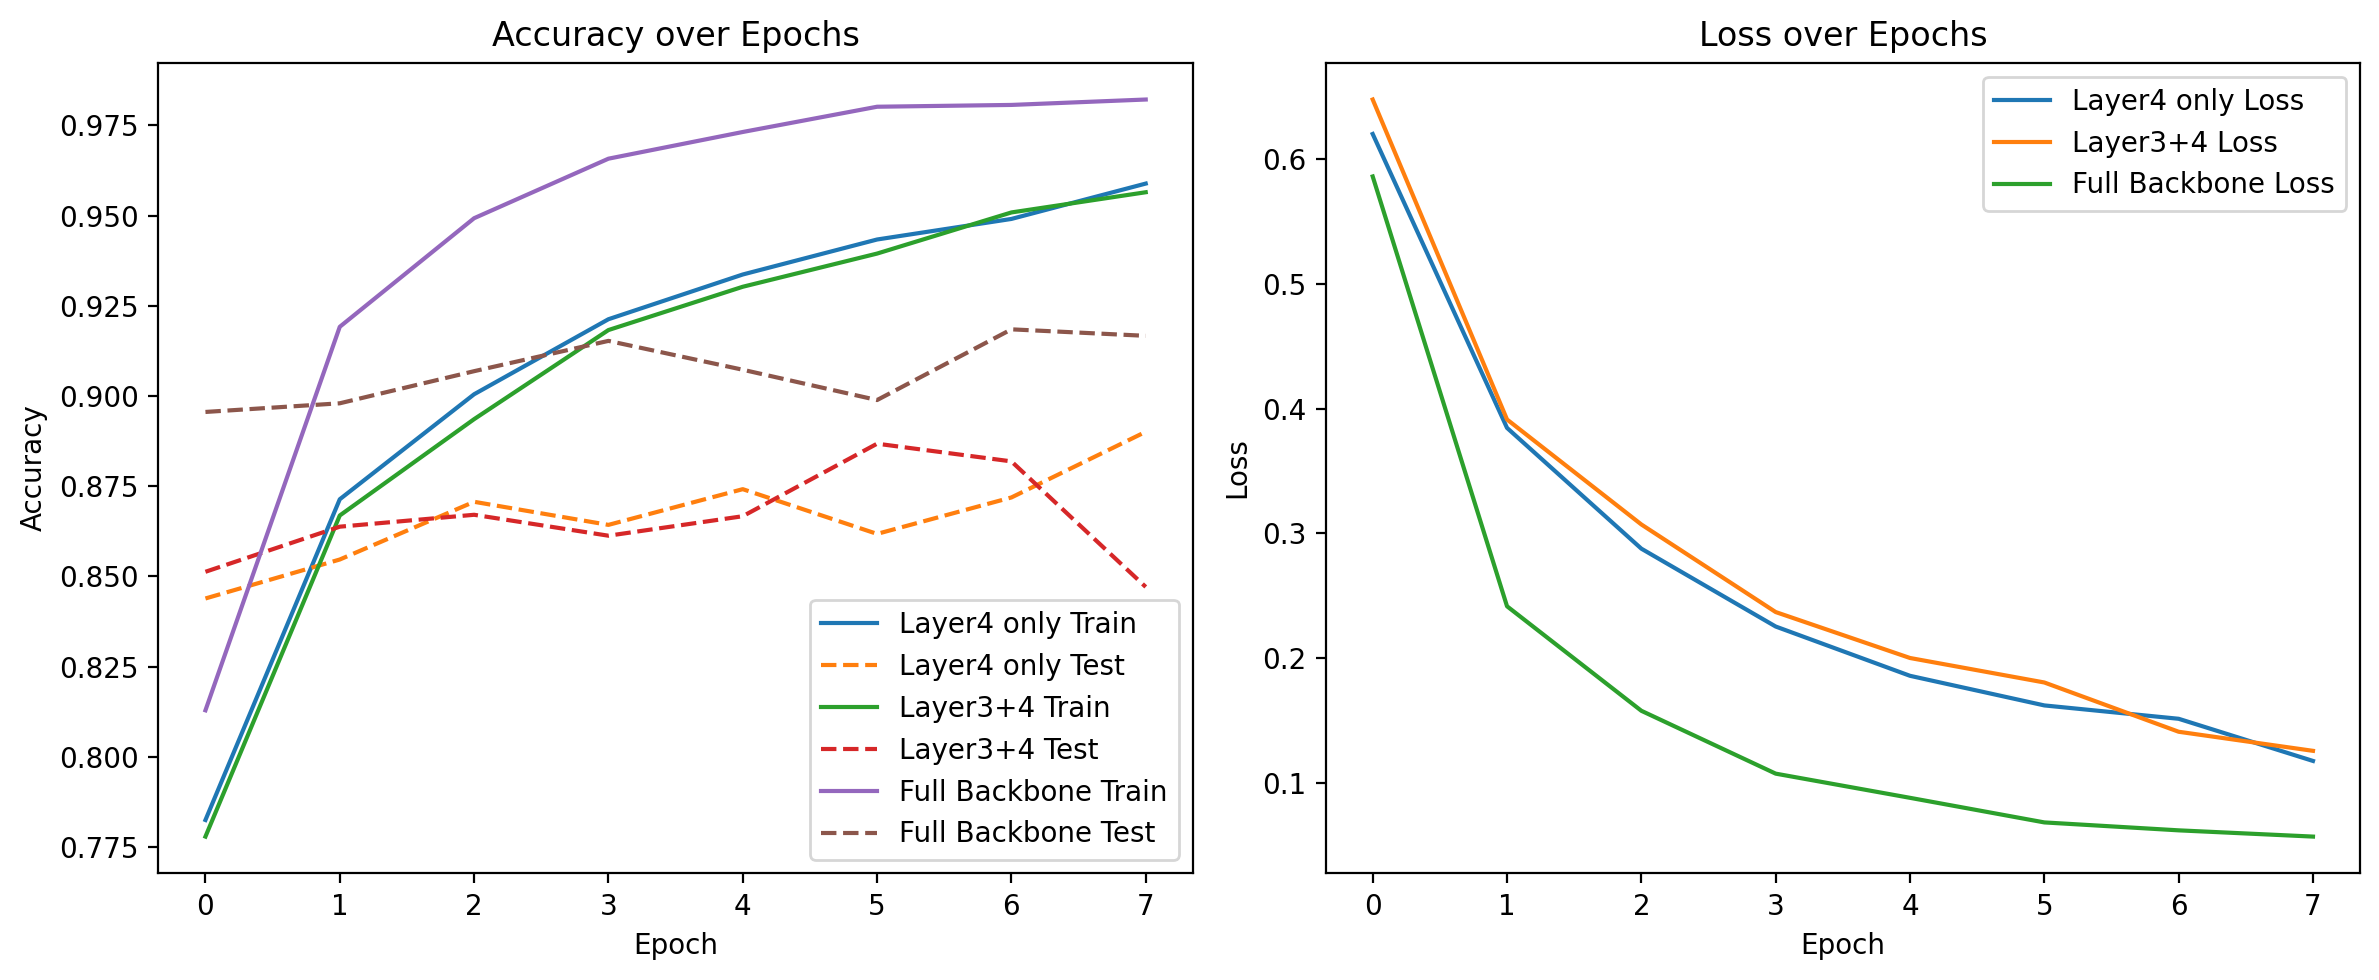

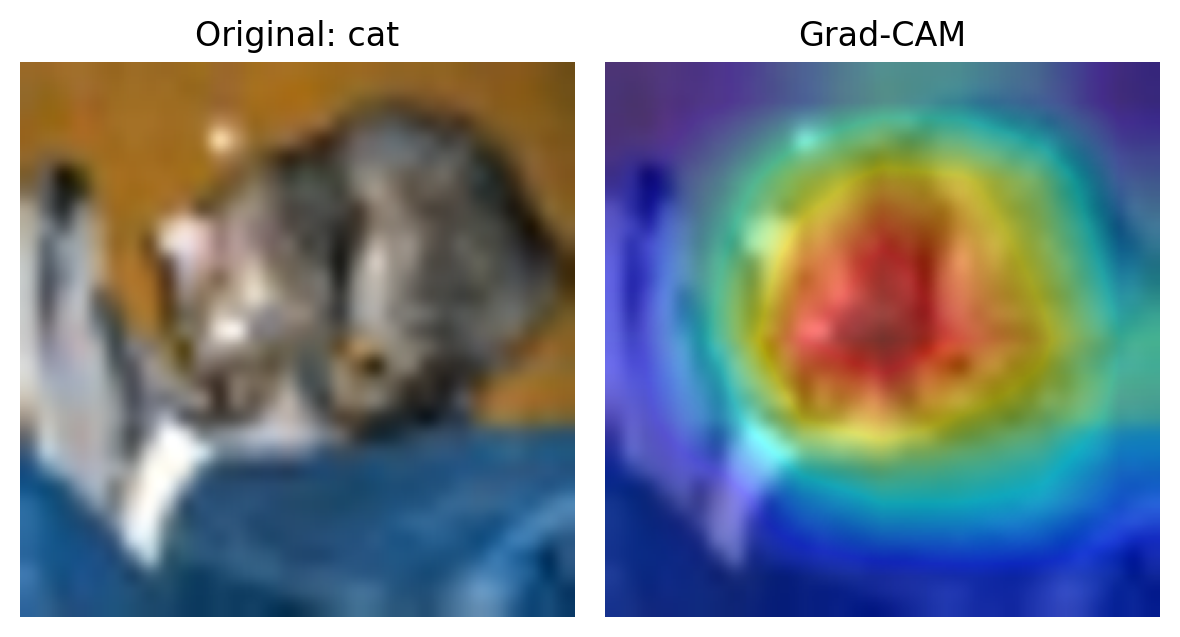

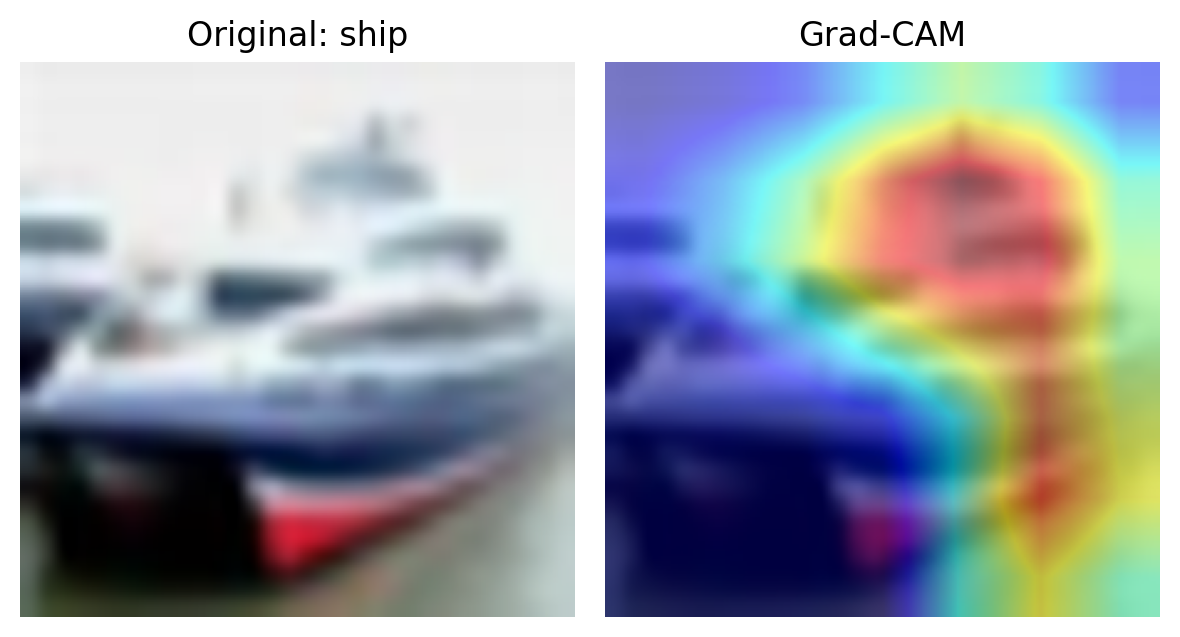

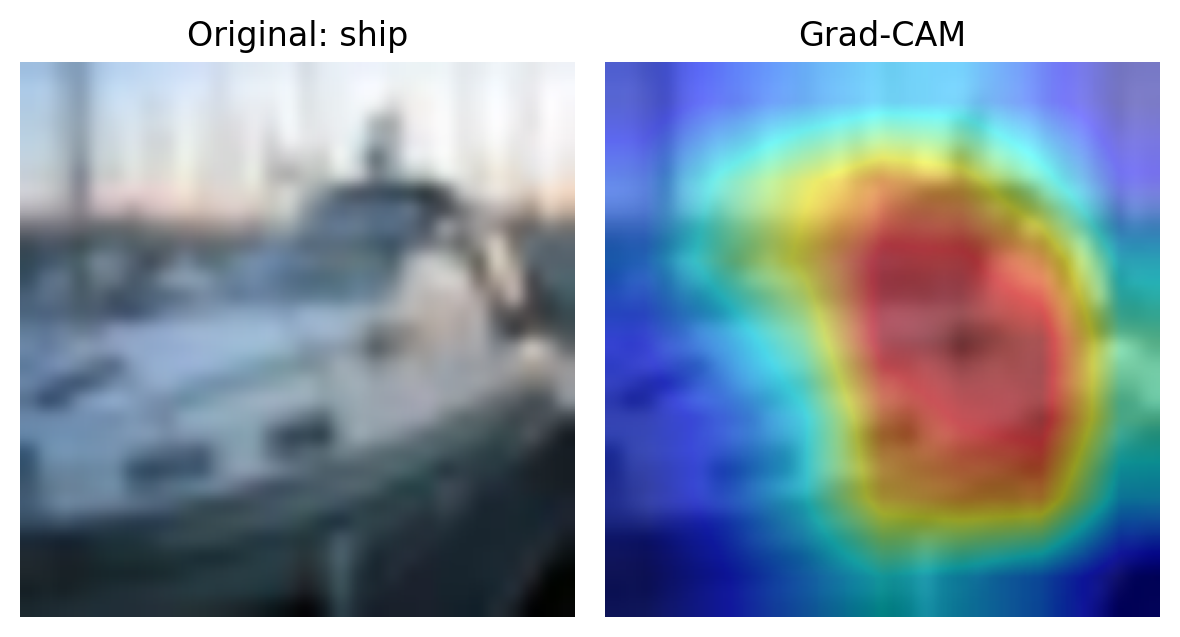

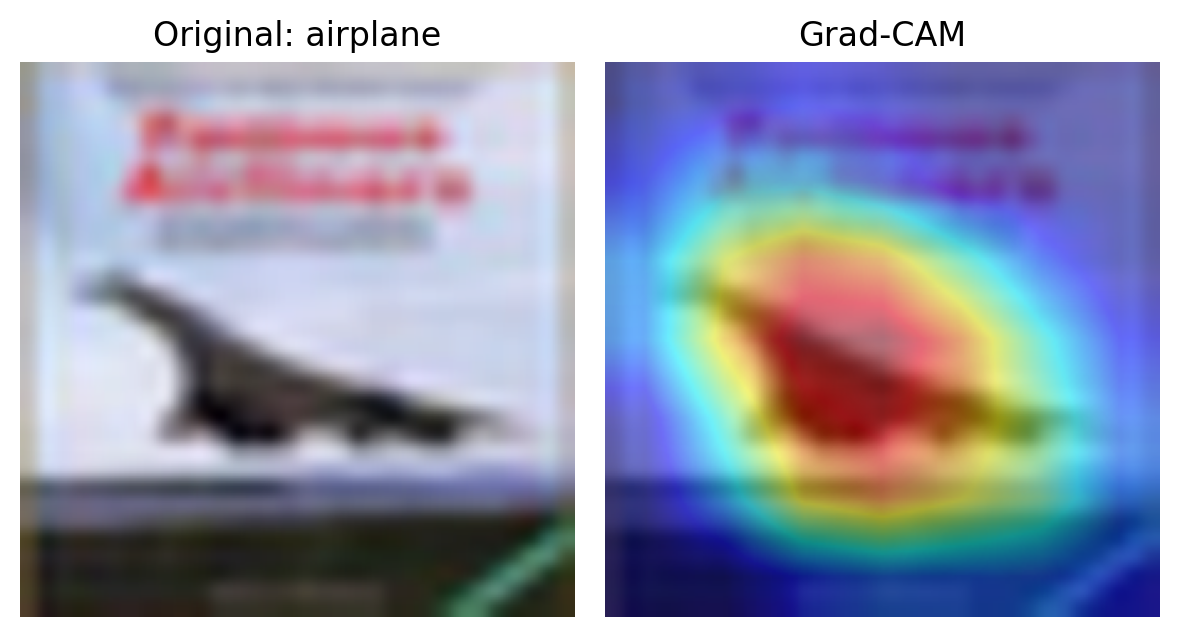

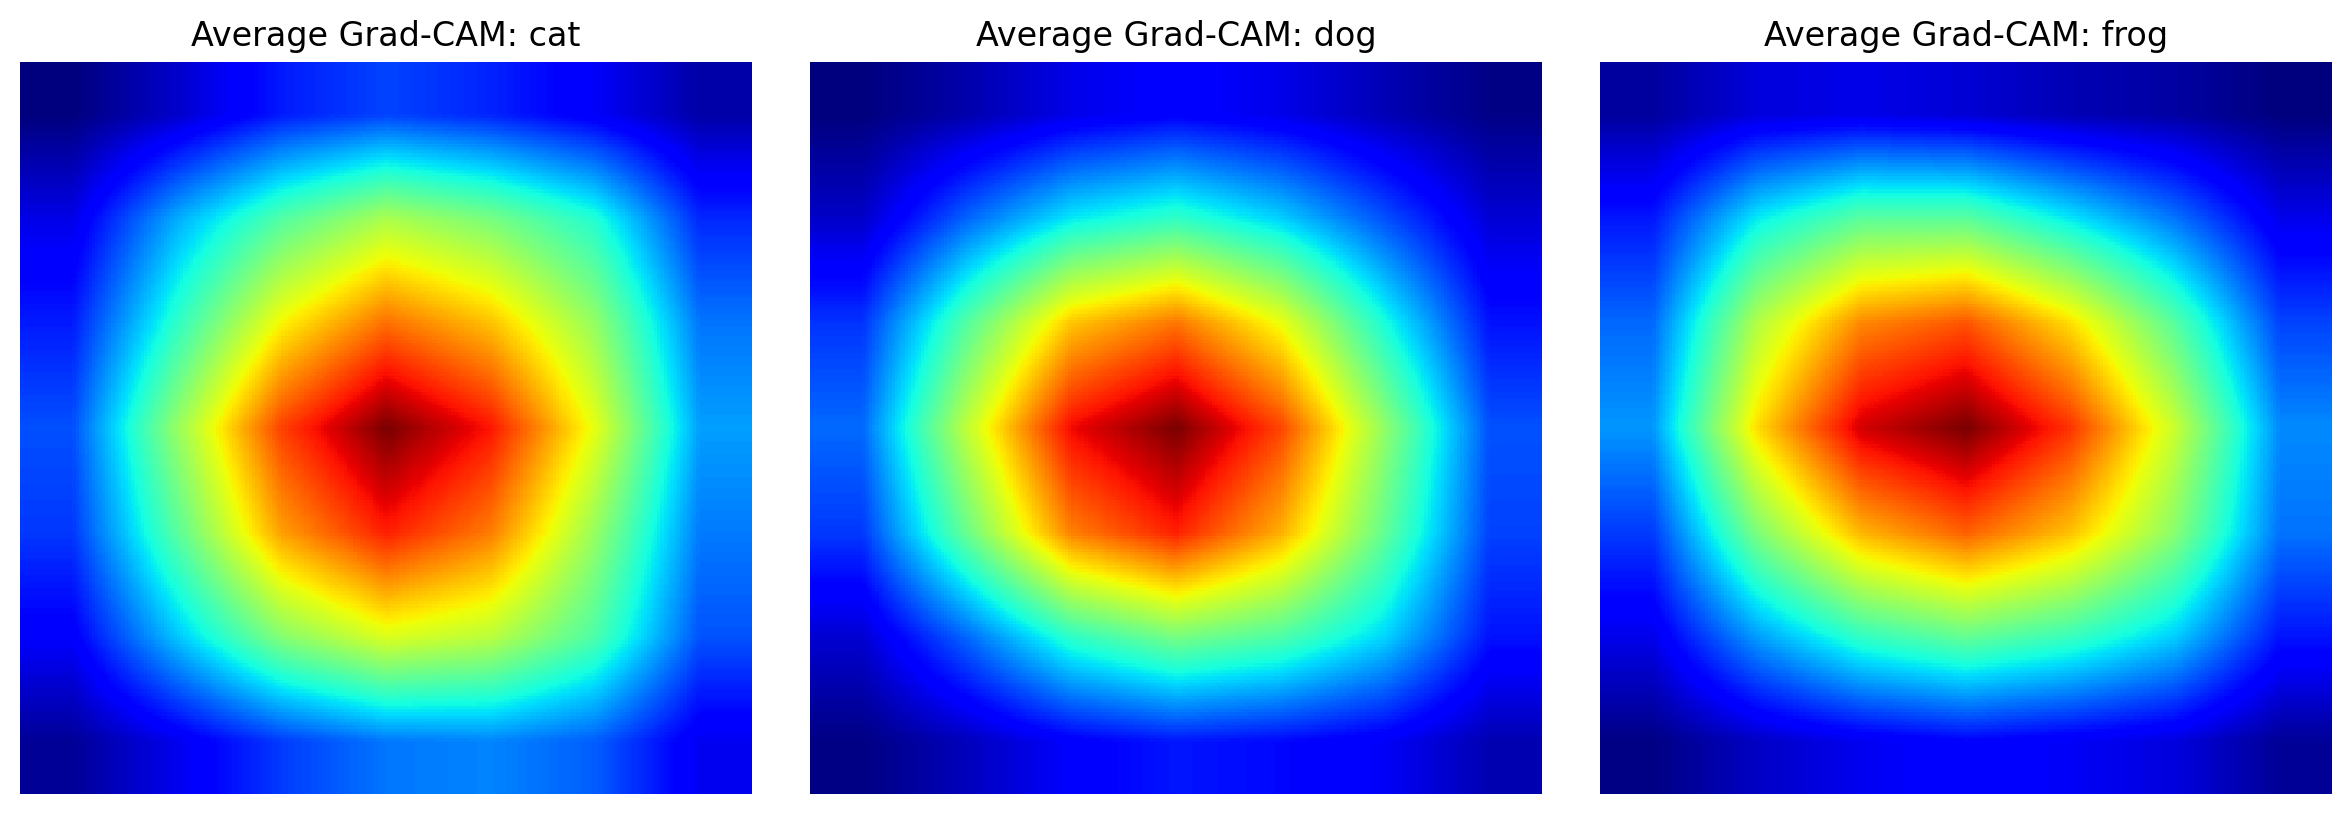

In [3]:
# =========================================================
# CIFAR-10 Gradual Fine-Tuning with Grad-CAM (High-Res Version)
# =========================================================

!pip install grad-cam -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- Create output folders -------------------
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# ------------------- Data Loading -------------------
def load_cifar10(batch_size=32, subset_size=10000):
    transform_train = transforms.Compose([
        transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    subset_indices = list(range(subset_size))
    trainset = torch.utils.data.Subset(trainset_full, subset_indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, trainset_full.classes

# ------------------- Model Building -------------------
def build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    for layer_name in fine_tune_layers:
        layer = getattr(model, layer_name)
        for param in layer.parameters():
            param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

# ------------------- Training Functions -------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_corrects = 0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(loader.dataset), running_corrects.double()/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
    return running_corrects.double()/len(loader.dataset)

def train_model_with_history(model, trainloader, testloader, epochs=8, lr=0.0005, phase_name="phase"):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_acc': [], 'test_acc': [], 'loss': []}

    for epoch in range(epochs):
        loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion)
        test_acc = evaluate(model, testloader)

        history['loss'].append(loss)
        history['train_acc'].append(train_acc.item())
        history['test_acc'].append(test_acc.item())

        print(f"[{phase_name}] Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    torch.save(model.state_dict(), f"models/model_{phase_name}.pth")
    return model, history

# ------------------- History Plot -------------------
def plot_history(histories, labels):
    plt.figure(figsize=(12,5), dpi=200)

    plt.subplot(1,2,1)
    for h,label in zip(histories,labels):
        plt.plot(h['train_acc'], label=f"{label} Train")
        plt.plot(h['test_acc'], '--', label=f"{label} Test")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    for h,label in zip(histories,labels):
        plt.plot(h['loss'], label=f"{label} Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("plots/accuracy_loss_comparison.png", dpi=300)
    plt.show()

# ------------------- Grad-CAM Functions -------------------
def gradcam_visualize(model, images, labels, classes, target_layer, max_images=4, save_dir="plots"):
    cam = GradCAM(model=model, target_layers=[target_layer])

    for i in range(min(max_images, len(images))):
        # Ensure high-res tensor for Grad-CAM
        input_tensor = F.resize(images[i], (224,224), interpolation=transforms.InterpolationMode.BICUBIC).unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        rgb_img = np.transpose(images[i].numpy(), (1,2,0))
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(6,6), dpi=200)
        plt.subplot(1,2,1)
        plt.title(f"Original: {classes[labels[i]]}")
        plt.imshow(rgb_img)
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.title("Grad-CAM")
        plt.imshow(visualization)
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{save_dir}/gradcam_{classes[labels[i]]}_{i}.png", dpi=300)
        plt.show()

# ------------------- Class-wise Average Grad-CAM -------------------
def class_average_gradcam(model, loader, target_layer, class_idx, max_images=10):
    cam = GradCAM(model=model, target_layers=[target_layer])
    images_collected = 0
    avg_cam = None
    for inputs, labels in loader:
        for i in range(len(labels)):
            if labels[i].item() == class_idx:
                input_tensor = inputs[i].unsqueeze(0).to(device)
                grayscale_cam = cam(input_tensor=input_tensor)[0, :]
                if avg_cam is None:
                    avg_cam = grayscale_cam
                else:
                    avg_cam += grayscale_cam
                images_collected += 1
                if images_collected >= max_images:
                    return avg_cam / images_collected
    return avg_cam / max(1, images_collected)

def plot_average_cams(avg_cams, titles, save_dir="plots"):
    plt.figure(figsize=(4*len(avg_cams),4), dpi=200)
    for i, cam in enumerate(avg_cams):
        plt.subplot(1,len(avg_cams),i+1)
        plt.title(titles[i])
        plt.imshow(cam, cmap='jet')
        plt.axis("off")
        plt.imsave(f"{save_dir}/avg_gradcam_{titles[i].replace(' ','_')}.png", cam, cmap='jet')
    plt.tight_layout()
    plt.show()

# ------------------- Run the Project -------------------
trainloader, testloader, classes = load_cifar10(batch_size=32, subset_size=10000)

histories = []
labels_phase = []

# Phase 1: layer4 only
model1 = build_model(freeze_backbone=True, fine_tune_layers=['layer4'], num_classes=len(classes))
model1, history1 = train_model_with_history(model1, trainloader, testloader, epochs=8, lr=0.0005, phase_name="layer4")
histories.append(history1)
labels_phase.append("Layer4 only")

# Phase 2: layer3 + layer4
model2 = build_model(freeze_backbone=True, fine_tune_layers=['layer3','layer4'], num_classes=len(classes))
model2, history2 = train_model_with_history(model2, trainloader, testloader, epochs=8, lr=0.0005, phase_name="layer3_4")
histories.append(history2)
labels_phase.append("Layer3+4")

# Phase 3: full backbone
model3 = build_model(freeze_backbone=False, fine_tune_layers=[], num_classes=len(classes))
model3, history3 = train_model_with_history(model3, trainloader, testloader, epochs=8, lr=0.0001, phase_name="full_backbone")
histories.append(history3)
labels_phase.append("Full Backbone")

# Plot accuracy & loss
plot_history(histories, labels_phase)

# Grad-CAM for random test images
dataiter = iter(testloader)
images, labels_batch = next(dataiter)
gradcam_visualize(model3, images, labels_batch, classes, target_layer=model3.layer4[-1], max_images=4)

# Class-wise average Grad-CAM
top_classes = ["cat","dog","frog"]
avg_cams = []
for cls in top_classes:
    idx = classes.index(cls)
    avg_cam = class_average_gradcam(model3, testloader, model3.layer4[-1], idx, max_images=10)
    avg_cams.append(avg_cam)
plot_average_cams(avg_cams, [f"Average Grad-CAM: {cls}" for cls in top_classes])
